<a href="https://colab.research.google.com/github/shruthimohan03/Text-to-Video-GenAI/blob/main/100imgs-captions_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image, ImageOps
import os

# Function to transform the images
def transform(image):
    image = ImageOps.fit(image, (224, 224), method=Image.Resampling.LANCZOS)  # Resize the image
    image = np.array(image) / 255.0  # Normalize the pixel values
    return image

# Load the captions file (Make sure to upload it to Colab)
captions_path = '/content/captions.txt'
with open(captions_path, 'r') as f:
    captions = f.read().splitlines()

# Create a dictionary mapping full image filenames (including .jpg) to captions
caption_dict = {}
for i, caption in enumerate(captions):
    if i == 0:  # Skip the header line if present
        continue
    parts = caption.split(',')
    if len(parts) == 2:
        caption_id, caption_text = parts
        caption_dict[caption_id.strip()] = caption_text.strip()

# Load the first 200 images and their captions
images = []
captions_subset = []
count = 0

# Specify the directory where images are stored (Make sure to upload images to Colab)
images_directory = '/content/Images-200'

for root, dirs, files in os.walk(images_directory):
    for file in files:
        if file.endswith('.jpg'):
            image_id = file
            if image_id in caption_dict:
                image_path = os.path.join(root, file)
                image = Image.open(image_path)
                image = transform(image)
                images.append(image)
                captions_subset.append(caption_dict[image_id])
                count += 1
                if count >= 100:  # Stop after 200 images
                    break
    if count >= 100:
        break

# Convert to numpy arrays
images = np.array(images)
captions = captions_subset

In [ ]:
# Model parameters
max_caption_length = 50
embedding_dim = 256
hidden_dim = 512
image_size = 112  # VGG19 requires input images to be 224x224

# Tokenize the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1

# Convert captions to numerical sequences
captions = tokenizer.texts_to_sequences(captions)
captions = pad_sequences(captions, maxlen=max_caption_length)

In [ ]:
# Define the text encoder
text_input = Input(shape=(max_caption_length,))
text_embedding = Embedding(vocab_size, embedding_dim)(text_input)
text_features = LSTM(hidden_dim)(text_embedding)

# Define the image encoder (using VGG19)
image_input = Input(shape=(image_size, image_size, 3))
image_features = VGG19(include_top=False, weights='imagenet')(image_input)
image_features = Flatten()(image_features)

# Combine text and image features
combined_features = tf.keras.layers.Concatenate()([text_features, image_features])

In [ ]:
# Define the decoder
decoder_output = Dense(image_size * image_size * 3, activation='sigmoid')(combined_features)
decoder_output = Reshape((image_size, image_size, 3))(decoder_output)

# Create the model
model = Model(inputs=[text_input, image_input], outputs=decoder_output)

# Dataset preparation
num_epochs = 10
batch_size = 4

def preprocess(image, caption):
    # Resize the image to the expected shape
    image = tf.image.resize(image, (image_size, image_size))

    # Pad the caption (same as before)
    caption_length = tf.shape(caption)[0]
    padding_needed = max_caption_length - caption_length
    padding = tf.maximum(padding_needed, 0)

    caption = tf.pad(caption, [[0, padding]])[:max_caption_length]

    return image, caption

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((images, captions))
dataset = dataset.map(preprocess)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse', run_eagerly=True)

# Train the model
history = model.fit(dataset.map(lambda img, cap: ((cap, img), img)), epochs=num_epochs)

print("Training complete.")


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - loss: 0.0759
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - loss: 0.0723
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - loss: 0.0720
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - loss: 0.0715
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step - loss: 0.0708
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - loss: 0.0717
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - loss: 0.0707
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - loss: 0.0685
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - loss: 0.0651
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - loss: 0.0631
Training complete.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
(1, 112, 112, 3)
uint8


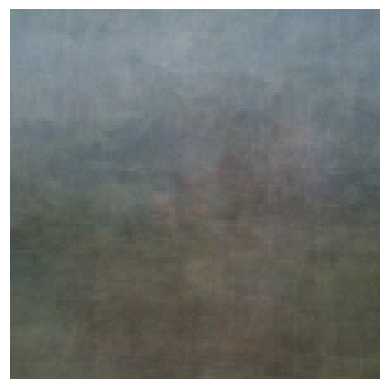

In [ ]:
# Example usage
text_input = tokenizer.texts_to_sequences(['a cat playing with a ball of yarn'])
text_input = pad_sequences(text_input, maxlen=max_caption_length)

# Generate a dummy image input (zeros)
dummy_image = np.zeros((1, image_size, image_size, 3))  # Placeholder for the image

# Predict the generated image
generated_image = model.predict([text_input, dummy_image])

# Scale the pixel values back to [0, 255]
generated_image = (generated_image * 255).astype(np.uint8)

# Before converting to Image, check the generated image array
print(generated_image.shape)  # Should be (1, image_size, image_size, 3)
print(generated_image.dtype)   # Should be uint8

# Convert the array to an image and display it
generated_image = Image.fromarray(generated_image[0])  # Access the first image in the batch

# Use matplotlib to display the image
import matplotlib.pyplot as plt

plt.imshow(generated_image)  # Display the image
plt.axis('off')  # Hide axes
plt.show()
